# Sentiment Analysis with Word2Vec, LSTM and Bayesian Optimization

In [1]:
# Imports
import pandas as pd
import numpy as np
import re
import nltk
import time
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

!pip install gensim
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, SpatialDropout1D
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
# Load dataset
df = pd.read_csv('/content/Reviews.csv', on_bad_lines='warn', engine='python')
df = df[['Text', 'Score']].dropna()
df = df[df['Score'] != 3]  # Remove neutral reviews
df['label'] = df['Score'].apply(lambda x: 1 if x > 3 else 0)

<ipython-input-3-598e98a26001>:2: ParserWarning: Skipping line 520077: unexpected end of data

  df = pd.read_csv('/content/Reviews.csv', on_bad_lines='warn', engine='python')


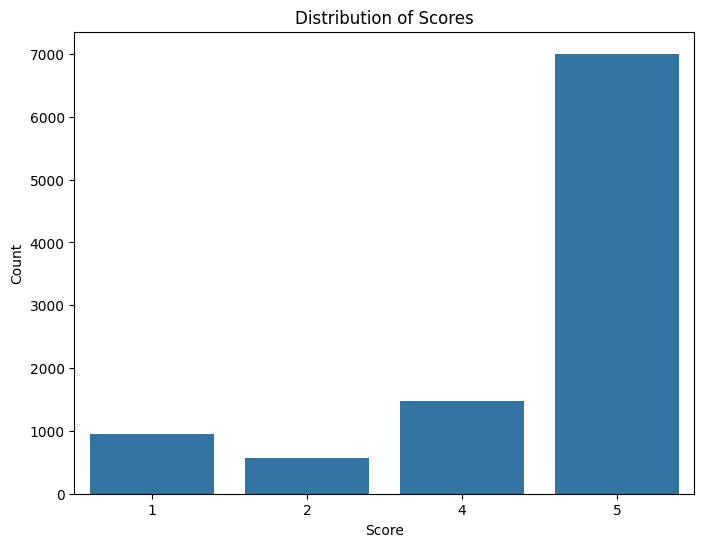

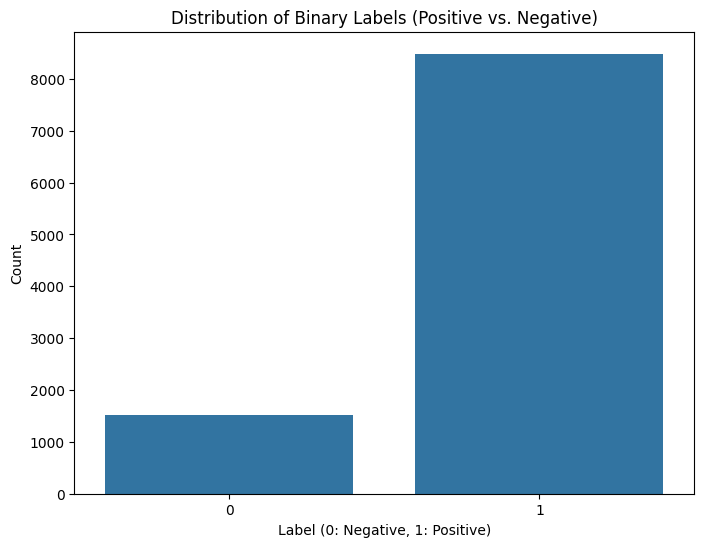

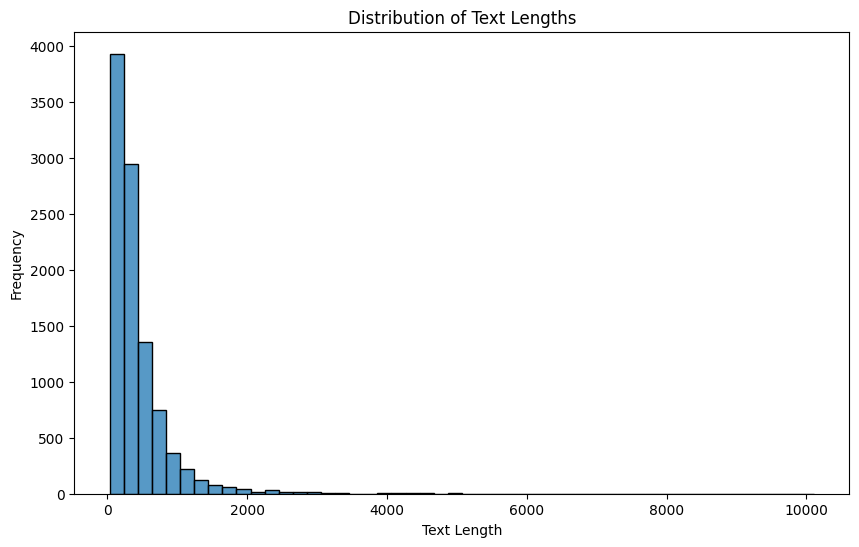

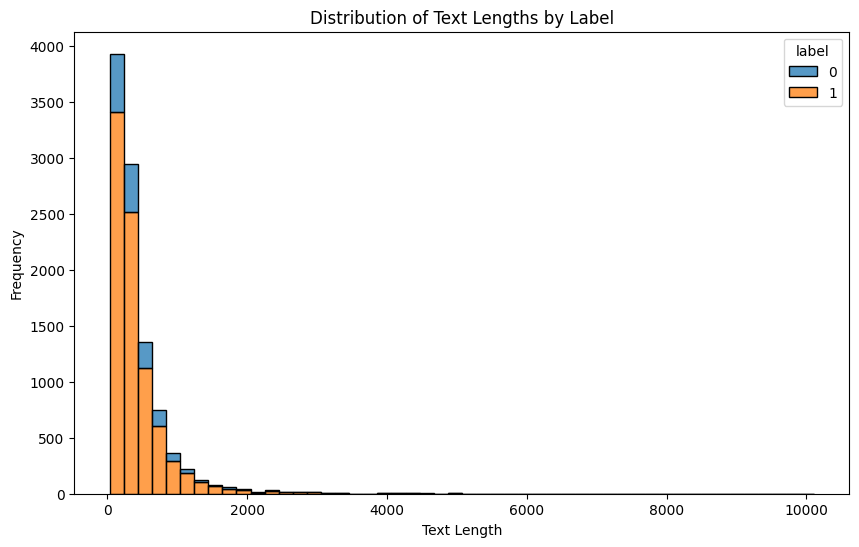

In [31]:
import matplotlib.pyplot as plt
# Check the distribution of scores
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Score')
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

# Check the distribution of the new binary label
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='label')
plt.title('Distribution of Binary Labels (Positive vs. Negative)')
plt.xlabel('Label (0: Negative, 1: Positive)')
plt.ylabel('Count')
plt.show()

# Distribution of review length
df['text_length'] = df['Text'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_length', bins=50)
plt.title('Distribution of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

# Distribution of text length by label
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='text_length', hue='label', bins=50, multiple="stack")
plt.title('Distribution of Text Lengths by Label')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()

In [30]:
# using 10000 review for model training and evaluation
df = df.sample(10000)

In [15]:
df.head()

,Text,Score,label,cleaned_text
152362,I love this product as a way to get protein in...,4,1,love product way get protein vegan plastic hol...
375085,DELICOUS! It's exactly the taste I have been l...,5,1,delicous exactly taste looking summer sausage ...
230654,As someone who kicked the coffee habit recentl...,5,1,someone kicked coffee habit recently enjoy tea...
376274,My husband and I used this to make macaroni an...,5,1,husband used make macaroni cheese last night s...
157395,I order four of Natural Calm and I receive one...,5,1,order four natural calm receive one calling re...


In [16]:
df.shape

(10000, 4)

In [17]:
# Text Cleaning Function
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text.lower())
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['cleaned_text'] = df['Text'].astype(str).apply(clean_text)

In [18]:
df.cleaned_text.head(5)

,cleaned_text
152362,love product way get protein vegan plastic hol...
375085,delicous exactly taste looking summer sausage ...
230654,someone kicked coffee habit recently enjoy tea...
376274,husband used make macaroni cheese last night s...
157395,order four natural calm receive one calling re...


In [19]:
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['cleaned_text'])
X = tokenizer.texts_to_sequences(df['cleaned_text'])
X = pad_sequences(X, maxlen=200)
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
# Build and train the LSTM model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=200))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

start_train = time.time()
history = model.fit(X_train, y_train, epochs=2, batch_size=128, validation_split=0.1, verbose=1)
end_train = time.time()

Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


57/57 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.8186 - loss: 0.5131 - val_accuracy: 0.8600 - val_loss: 0.3637
Epoch 2/2
57/57 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.8639 - loss: 0.3217 - val_accuracy: 0.8950 - val_loss: 0.2886


In [21]:
# Evaluate the model
start_test = time.time()
y_pred = (model.predict(X_test) > 0.5).astype("int32")
end_test = time.time()

acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)
print("Training Time:", end_train - start_train)
print("Testing Time:", end_test - start_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step
Accuracy: 0.888
Training Time: 160.20028281211853
Testing Time: 5.821029424667358


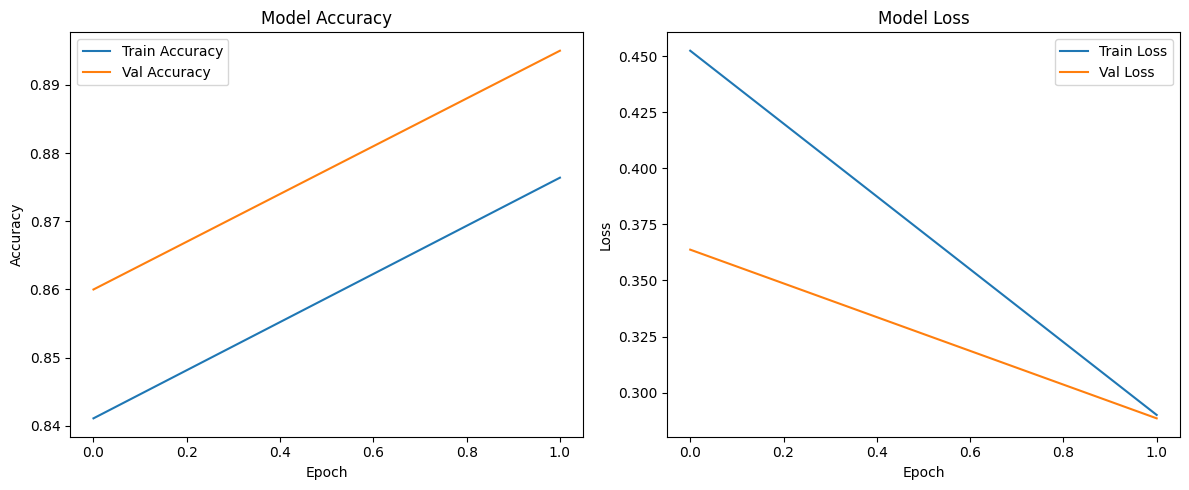

In [26]:
# Visualization
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

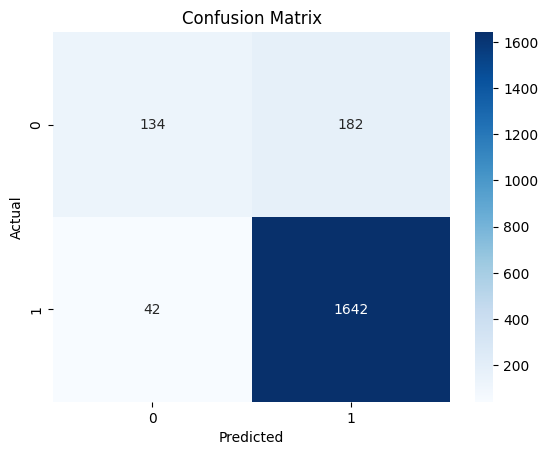

In [23]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()